In [1]:
from google.colab import drive
drive.mount('/content/drive')

!tar -xvf "/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/mp1_release.tar.gz" -C "/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1"

Mounted at /content/drive
mp1_release/
mp1_release/vocab.txt
mp1_release/scripts/
mp1_release/scripts/utils.py
mp1_release/scripts/eval_embs.py
mp1_release/data/
mp1_release/data/dev/
mp1_release/data/dev/PG60617_tokens.txt
mp1_release/data/dev/PG62614_tokens.txt
mp1_release/data/dev/PG60618_tokens.txt
mp1_release/data/dev/PG69618_tokens.txt
mp1_release/data/dev/PG65613_tokens.txt
mp1_release/data/train/
mp1_release/data/train/PG49614_tokens.txt
mp1_release/data/train/PG65616_tokens.txt
mp1_release/data/train/PG16617_tokens.txt
mp1_release/data/train/PG58613_tokens.txt
mp1_release/data/train/PG38612_tokens.txt
mp1_release/data/train/PG51612_tokens.txt
mp1_release/data/train/PG54617_tokens.txt
mp1_release/data/train/PG48615_tokens.txt
mp1_release/data/train/PG53613_tokens.txt
mp1_release/data/train/PG55618_tokens.txt
mp1_release/data/train/PG59614_tokens.txt
mp1_release/data/train/PG50619_tokens.txt
mp1_release/data/train/PG66610_tokens.txt
mp1_release/data/train/PG54618_tokens.txt
mp1_

In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

!cp /content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/mp1_release/scripts/eval_embs.py /content/
!cp /content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/mp1_release/scripts/utils.py /content/

from eval_embs import get_eval_stats

from utils import get_word2ix, get_files, process_data
torch.manual_seed(66)

In [3]:
word2ix = get_word2ix(path="/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/mp1_release/vocab.txt")

train_files = get_files(path="/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/mp1_release/data/train/")
dev_files = get_files(path="/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/mp1_release/data/dev/")

processed_train_data = process_data(train_files, 5, word2ix)
processed_dev_data = process_data(dev_files, 5, word2ix)

In [4]:
def create_input_output(dataset, window):
  X = []
  Y = []
  for files in dataset:
    for index, word in enumerate(files):
      if index-window < 0 or index+window >= len(files):
        continue
      temp_x = []
      for j in range(index-window, index+window+1):
        if(j != index):
          temp_x.append(files[j])
      temp_target = word
      X.append(temp_x)
      Y.append(temp_target)
  return np.array(X), np.array(Y)

X_train, y_train = create_input_output(processed_train_data, 5)
X_dev, y_dev = create_input_output(processed_dev_data, 5)

print(X_train.shape, y_train.shape)

(1860640, 10) (1860640,)


In [5]:
from torch.utils.data import Dataset, DataLoader

X_train = torch.tensor(X_train)
y_train = torch.tensor(y_train)
X_dev = torch.tensor(X_dev)
y_dev = torch.tensor(y_dev)

train_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=64)
dev_dataloader = DataLoader(list(zip(X_train,y_train)), shuffle=True, batch_size=64)

In [6]:
class CBOW_Model(nn.Module):
  def __init__(self, vocab_size, embedding_dimension, embed_max_norm):
    # , embed_max_norm
    super(CBOW_Model, self).__init__()
    self.embeddings = nn.Embedding(
        num_embeddings= vocab_size,
        embedding_dim= embedding_dimension,
        max_norm= embed_max_norm,
        )
    self.linear = nn.Linear(
        in_features= embedding_dimension,
        out_features= vocab_size,
        )
  def forward(self, inputs_):
    x = self.embeddings(inputs_)
    x = x.mean(axis=1)
    x = self.linear(x)
    return x

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [8]:
def batch_gd(model, criterion, optimizer, train_loader, dev_loader, epochs = 10):
  train_losses = np.zeros(epochs)
  dev_losses = np.zeros(epochs)

  for i in range(epochs):
    train_loss = []
    for inputs, targets in train_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      # outputs = outputs.to('cpu')
      # outputs = outputs.detach().numpy()
      # outputs = np.argmax(outputs, axis = 1)
      # print("outputs=",outputs)
      # print("Targets=",targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())
    train_loss = np.mean(train_loss)

    dev_loss = []
    for inputs, targets in dev_loader:
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      dev_loss.append(loss.item())
    dev_loss = np.mean(dev_loss)

    train_losses[i] = train_loss
    dev_losses[i] = dev_loss

    print(f'Epoch {i+1}/{epochs}, Train Loss: {train_loss:.4f},\
        Dev Loss: {dev_loss:.4f}')

  return train_losses, dev_losses, model


For learning rate =  0.1
Epoch 1/10, Train Loss: 7.1272,        Dev Loss: 7.0485
Epoch 2/10, Train Loss: 7.1175,        Dev Loss: 7.0719
Epoch 3/10, Train Loss: 7.1117,        Dev Loss: 7.0873
Epoch 4/10, Train Loss: 7.1102,        Dev Loss: 7.0230
Epoch 5/10, Train Loss: 7.1095,        Dev Loss: 7.0619
Epoch 6/10, Train Loss: 7.1104,        Dev Loss: 7.0810
Epoch 7/10, Train Loss: 7.1104,        Dev Loss: 7.0628
Epoch 8/10, Train Loss: 7.1100,        Dev Loss: 7.0653
Epoch 9/10, Train Loss: 7.1111,        Dev Loss: 7.0837
Epoch 10/10, Train Loss: 7.1114,        Dev Loss: 7.0619
Best Development Loss =  7.064719019373089


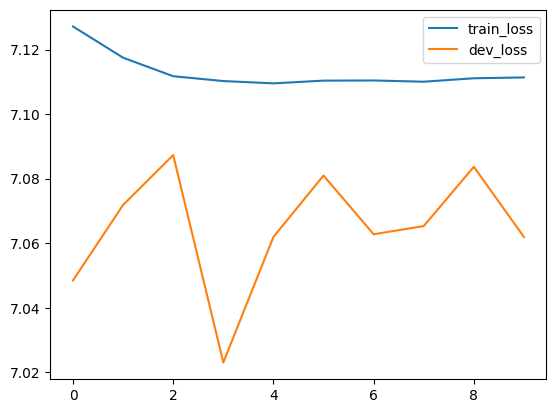

For learning rate =  0.01
Epoch 1/10, Train Loss: 6.4070,        Dev Loss: 6.2202
Epoch 2/10, Train Loss: 6.2541,        Dev Loss: 6.1701
Epoch 3/10, Train Loss: 6.2224,        Dev Loss: 6.1382
Epoch 4/10, Train Loss: 6.2050,        Dev Loss: 6.1256
Epoch 5/10, Train Loss: 6.1935,        Dev Loss: 6.1160
Epoch 6/10, Train Loss: 6.1855,        Dev Loss: 6.1112
Epoch 7/10, Train Loss: 6.1789,        Dev Loss: 6.1013
Epoch 8/10, Train Loss: 6.1747,        Dev Loss: 6.0994
Epoch 9/10, Train Loss: 6.1716,        Dev Loss: 6.0986
Epoch 10/10, Train Loss: 6.1691,        Dev Loss: 6.0935
Best Development Loss =  6.127415266533293


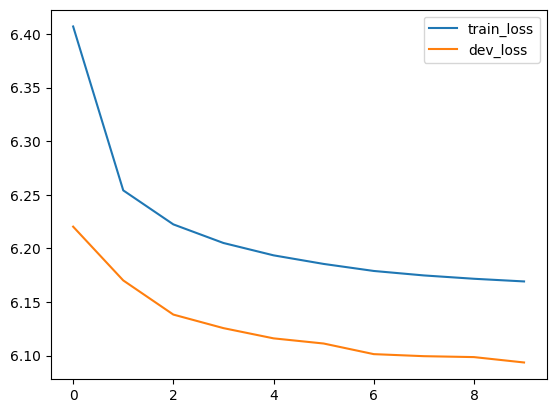

For learning rate =  0.001
Epoch 1/10, Train Loss: 6.4652,        Dev Loss: 6.1790
Epoch 2/10, Train Loss: 6.1510,        Dev Loss: 6.0195
Epoch 3/10, Train Loss: 6.0427,        Dev Loss: 5.9242
Epoch 4/10, Train Loss: 5.9708,        Dev Loss: 5.8517
Epoch 5/10, Train Loss: 5.9148,        Dev Loss: 5.7952
Epoch 6/10, Train Loss: 5.8700,        Dev Loss: 5.7489
Epoch 7/10, Train Loss: 5.8322,        Dev Loss: 5.7073
Epoch 8/10, Train Loss: 5.7986,        Dev Loss: 5.6701
Epoch 9/10, Train Loss: 5.7687,        Dev Loss: 5.6365
Epoch 10/10, Train Loss: 5.7421,        Dev Loss: 5.6071
Best Development Loss =  5.813960371861143


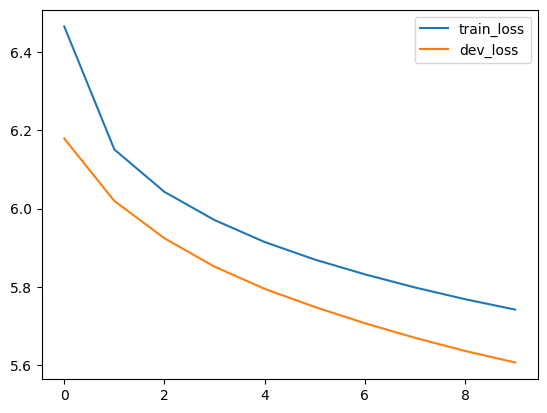

For learning rate =  0.0001
Epoch 1/10, Train Loss: 7.0822,        Dev Loss: 6.6403
Epoch 2/10, Train Loss: 6.5635,        Dev Loss: 6.4848
Epoch 3/10, Train Loss: 6.4500,        Dev Loss: 6.3989
Epoch 4/10, Train Loss: 6.3781,        Dev Loss: 6.3368
Epoch 5/10, Train Loss: 6.3240,        Dev Loss: 6.2885
Epoch 6/10, Train Loss: 6.2801,        Dev Loss: 6.2477
Epoch 7/10, Train Loss: 6.2427,        Dev Loss: 6.2121
Epoch 8/10, Train Loss: 6.2096,        Dev Loss: 6.1804
Epoch 9/10, Train Loss: 6.1799,        Dev Loss: 6.1515
Epoch 10/10, Train Loss: 6.1527,        Dev Loss: 6.1254


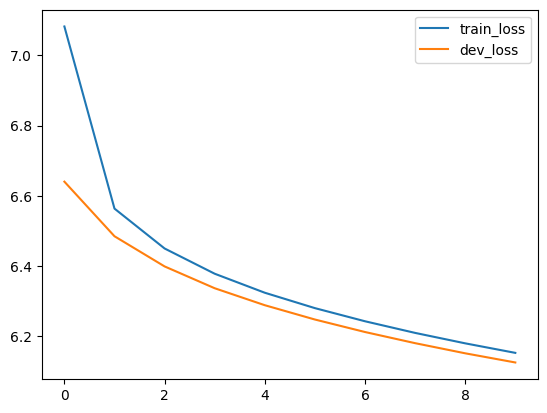

In [20]:
learning_rates = np.array([0.1,0.01, 0.001, 0.0001])
best_dev_loss = 0

for i in range(4):
  vocab_size = len(word2ix)

  cbow_model = CBOW_Model(vocab_size=vocab_size, embedding_dimension=100, embed_max_norm = 1)
  # , embed_max_norm = 1
  cbow_model.to(device)
  criterion = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(cbow_model.parameters(), lr=learning_rates[i])
  print("For learning rate = ",learning_rates[i])

  train_losses, dev_losses, ret_model = batch_gd(
      cbow_model, criterion, optimizer, train_dataloader, dev_dataloader, epochs=10
  )

  # embeddings = list(ret_model.parameters())[0]
  # print("Embedding:")
  # print(embeddings)

  # print("Parameter Tensor")
  # for param_tensor in ret_model.state_dict():
  #   print(param_tensor, "\t", ret_model.state_dict()[param_tensor].size())

  # print("Optimizer Variable")
  # for var_name in optimizer.state_dict():
  #   print(var_name, "\t", optimizer.state_dict()[var_name])
  avg_dev_losses = np.mean(dev_losses)

  if(i == 0):
    best_dev_loss = avg_dev_losses
    torch.save({
            "model_param": ret_model.state_dict(),
            "optim_param": optimizer.state_dict(),
            "lowest_dev_loss": best_dev_loss,
            "learning_rate": learning_rates[i]},
               f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/best_model.pth")

    print('Best Development Loss = ', best_dev_loss)
  elif avg_dev_losses < best_dev_loss:
    best_dev_loss = avg_dev_losses
    torch.save({
            "model_param": ret_model.state_dict(),
            "optim_param": optimizer.state_dict(),
            "lowest_dev_loss": best_dev_loss,
            "learning_rate": learning_rates[i]},
               f"/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/best_model.pth")
    print('Best Development Loss = ', best_dev_loss)

  plt.plot(train_losses, label = 'train_loss')
  plt.plot(dev_losses, label = 'dev_loss')
  plt.legend()
  plt.show()

In [9]:
vocab_size = len(word2ix)
embedding_dimension=100

model_path = "/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/best_model.pth"
checkpoint = torch.load(model_path)
cbow_model = CBOW_Model(vocab_size=vocab_size, embedding_dimension=100, embed_max_norm = 1)
# , embed_max_norm = 1
optimizer = torch.optim.Adam(cbow_model.parameters(), checkpoint["learning_rate"])
cbow_model.load_state_dict(checkpoint["model_param"])
optimizer.load_state_dict(checkpoint["optim_param"])
cbow_model.to(device)



CBOW_Model(
  (embeddings): Embedding(18061, 100, max_norm=1)
  (linear): Linear(in_features=100, out_features=18061, bias=True)
)

In [10]:
print(checkpoint["learning_rate"])

0.001


In [11]:
embeddings = list(cbow_model.parameters())[1]
print("Embedding:")
print(embeddings)

Embedding:
Parameter containing:
tensor([[ 1.5994, -2.4193, -2.0430,  ..., -1.6789, -0.0558,  1.2008],
        [-0.1417, -2.7800, -0.5788,  ..., -3.0058,  3.3689,  0.9986],
        [ 2.7405, -2.6262, -1.9813,  ..., -2.2797,  3.5461,  1.0027],
        ...,
        [ 0.8403, -1.0260, -1.0239,  ...,  0.5139, -0.3976,  1.2342],
        [-0.7698,  2.7605,  2.5145,  ...,  1.4765, -1.4573, -2.1456],
        [-0.9369,  2.7522,  2.5014,  ...,  1.6088, -1.5009, -2.1655]],
       device='cuda:0', requires_grad=True)


In [12]:
embed_matrix = cbow_model.embeddings.weight.detach().cpu().numpy()
print(embed_matrix.shape)

(18061, 100)


In [13]:
with open('/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/embeddings.txt', 'w') as f:
  f.write(str(vocab_size))
  f.write(' ')
  f.write(str(embedding_dimension))
  f.write('\n')
  for key in word2ix:
    f.write(str(key))
    f.write(' ')
    id = word2ix[key]
    for j in range(embedding_dimension):
      f.write(str(embed_matrix[id][j]))
      f.write(' ')
    f.write('\n')

In [14]:
!mkdir test_sets
!cp /content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/mp1_release/test_files/questions-words_headered.txt /content/test_sets/
!cp /content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/mp1_release/test_files/wordsim_similarity_goldstandard.txt /content/test_sets/

In [15]:
!python eval_embs.py --emb_file '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/embeddings.txt'

Word Similarity Test Pearson Correlation: 0.37845984822247786
Accuracy on Analogy Test: 0.062403697996918334


# 1) Best Learning Rate and The Lowest Development Set Loss

In [16]:
print("Best Learning Rate = ",checkpoint["learning_rate"])
print("Lowest Development Set Loss = ",checkpoint["lowest_dev_loss"])

Best Learning Rate =  0.001
Lowest Development Set Loss =  5.813960371861143


#2(a). Cosine Similarity between pairs

In [17]:
from numpy import dot
from numpy.linalg import norm

def cos_sim(a,b):
  sim = dot(a, b)/(norm(a)*norm(b))
  return sim

In [54]:
def stoi(key):
  isKeyPresent = key in word2ix
  if isKeyPresent == True:
    return word2ix[key]
  else:
    return word2ix['[UNK]']

In [19]:
def get_embedding(a):
  return embed_matrix[a]

In [20]:
def similarity_score(pair):
  e1 = get_embedding(stoi(pair[0]))
  e2 = get_embedding(stoi(pair[1]))

  return cos_sim(e1, e2)

In [21]:
def compare_pairs(pair1, pair2):
  s1 = similarity_score(pair1)
  s2 = similarity_score(pair2)
  print('Similarity score of ', pair1,' =',s1)
  print('Similarity score of ', pair2,' =',s2)
  if s1 > s2:
    print(pair1, ' is closer')
  elif s1 < s2:
    print(pair2, ' is closer')
  else:
    print('both the pair are in similar cosine distance')

In [22]:
pair1 = ['cat', 'tiger']
pair2 = ['plane', 'human']
compare_pairs(pair1, pair2)

Similarity score of  ['cat', 'tiger']  = 0.1782883
Similarity score of  ['plane', 'human']  = 0.25194982
['plane', 'human']  is closer


In [23]:
pair1 = ['my', 'mine']
pair2 = ['happy', 'human']
compare_pairs(pair1, pair2)

Similarity score of  ['my', 'mine']  = 0.47246733
Similarity score of  ['happy', 'human']  = -0.04108724
['my', 'mine']  is closer


In [24]:
pair1 = ['happy', 'cat']
pair2 = ['king', 'princess']
compare_pairs(pair1, pair2)

Similarity score of  ['happy', 'cat']  = 0.094843715
Similarity score of  ['king', 'princess']  = 0.29489377
['king', 'princess']  is closer


In [25]:
pair1 = ['ball', 'racket']
pair2 = ['good', 'ugly']
compare_pairs(pair1, pair2)

Similarity score of  ['ball', 'racket']  = 0.212945
Similarity score of  ['good', 'ugly']  = 0.14672194
['ball', 'racket']  is closer


In [26]:
pair1 = ['cat', 'racket']
pair2 = ['good', 'bad']
compare_pairs(pair1, pair2)

Similarity score of  ['cat', 'racket']  = 0.41509384
Similarity score of  ['good', 'bad']  = 0.4965547
['good', 'bad']  is closer


#2(b). most similar word in the vocabulary with the vector (wb - wa + wc)

In [27]:
from numpy import dot
from numpy.linalg import norm

def cos_sim_mat_vec(a,b):
  sim = dot(a, b)/(norm(a, axis=1)*norm(b))
  return sim

In [28]:
def solve_analogy(w1, w2, w3):
  e1 = get_embedding(stoi(w1))
  e2 = get_embedding(stoi(w2))
  e3 = get_embedding(stoi(w3))
  target = e2 - e1 + e3
  ind_close = np.argsort(-cos_sim_mat_vec(embed_matrix,target))[0]
  key_list = list(word2ix.keys())
  val_list = list(word2ix.values())
  position = val_list.index(ind_close)
  print('Closest one = ','[',w1,':',w2,',',w3,':',key_list[position],']')

  ind_close = np.argsort(-cos_sim_mat_vec(embed_matrix,target))[1]
  key_list = list(word2ix.keys())
  val_list = list(word2ix.values())
  position = val_list.index(ind_close)
  print('Second Closest= ','[',w1,':',w2,',',w3,':',key_list[position],']')



In [29]:
solve_analogy('king','queen', 'man')

Closest one =  [ king : queen , man : man ]
Second Closest=  [ king : queen , man : lady ]


In [30]:
solve_analogy('king','queen', 'prince')

Closest one =  [ king : queen , prince : prince ]
Second Closest=  [ king : queen , prince : queen ]


In [31]:
solve_analogy('king','man','queen')

Closest one =  [ king : man , queen : man ]
Second Closest=  [ king : man , queen : lady ]


In [32]:
solve_analogy('woman', 'man', 'princess')

Closest one =  [ woman : man , princess : princess ]
Second Closest=  [ woman : man , princess : shogun ]


In [33]:
solve_analogy('prince', 'princess', 'man')

Closest one =  [ prince : princess , man : man ]
Second Closest=  [ prince : princess , man : woman ]


# 3(a). Word Similarity test

In [34]:
compare_pairs(['day', 'night'], ['dawn','plane'])

Similarity score of  ['day', 'night']  = 0.6989168
Similarity score of  ['dawn', 'plane']  = -0.034828883
['day', 'night']  is closer


In [35]:
compare_pairs(['country', 'citizen'], ['village','office'])

Similarity score of  ['country', 'citizen']  = 0.49361527
Similarity score of  ['village', 'office']  = 0.2638116
['country', 'citizen']  is closer


In [36]:
compare_pairs(['dawn', 'afternoon'], ['dawn','tomorrow'])

Similarity score of  ['dawn', 'afternoon']  = 0.35480067
Similarity score of  ['dawn', 'tomorrow']  = 0.3302696
['dawn', 'afternoon']  is closer


In [37]:
compare_pairs(['hardware', 'mobile'], ['college','student'])

Similarity score of  ['hardware', 'mobile']  = 0.14813052
Similarity score of  ['college', 'student']  = 0.3277298
['college', 'student']  is closer


In [38]:
compare_pairs(['law', 'lawyer'], ['market','young'])

Similarity score of  ['law', 'lawyer']  = 0.109953426
Similarity score of  ['market', 'young']  = -0.12075043
['law', 'lawyer']  is closer


# 3(b). Word Analogy test.

In [39]:
solve_analogy('country', 'citizen', 'planet')

Closest one =  [ country : citizen , planet : planet ]
Second Closest=  [ country : citizen , planet : citizen ]


In [40]:
solve_analogy('early','late','expensive')

Closest one =  [ early : late , expensive : expensive ]
Second Closest=  [ early : late , expensive : ninety ]


In [41]:
solve_analogy('deep', 'shallow', 'early')

Closest one =  [ deep : shallow , early : early ]
Second Closest=  [ deep : shallow , early : colonial ]


In [42]:
solve_analogy('battery', 'light', 'engine')

Closest one =  [ battery : light , engine : engine ]
Second Closest=  [ battery : light , engine : light ]


In [43]:
solve_analogy('leaf', 'tree', 'hand')

Closest one =  [ leaf : tree , hand : hand ]
Second Closest=  [ leaf : tree , hand : ear ]


#4)Evaluating Embedding on test files

In [44]:
!python eval_embs.py --emb_file '/content/drive/MyDrive/NLPwithDeepLearning/Assignment-1/embeddings.txt'

Word Similarity Test Pearson Correlation: 0.37845984822247786
Accuracy on Analogy Test: 0.062403697996918334


#Extra Credit: Projection on 2D

In [61]:
words_to_print = ['horse', 'cat', 'dog', 'I', 'he', 'she', 'it', 'her', 'his', 'our', 'we', 'in', 'on',
                  'from', 'to', 'at', 'by', 'man', 'woman', 'boy', 'girl', 'king', 'queen', 'prince',
                  'princess']
# print(len(words_to_print))
indices = np.zeros(len(words_to_print))
for i in range(indices.shape[0]):
  # print(words_to_print[i])
  indices[i] = stoi(words_to_print[i])
indices = indices.astype('int32')
embed2_matrix = embed_matrix[indices,:]
key_list = list(word2ix.keys())
key_list2 = []
for i in range(indices.shape[0]):
  key_list2.append(key_list[indices[i]])
# print(key_list2)

In [63]:
print(embed2_matrix.shape)

(25, 100)


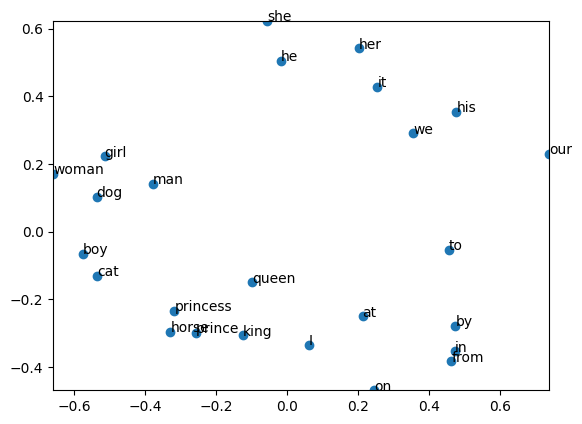

In [64]:
import plotly.express as px
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embed2_matrix = pca.fit_transform(embed2_matrix)

x_coords = embed2_matrix[:, 0]
y_coords = embed2_matrix[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(words_to_print, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()